# Azure Cognitive Services : Text Analytics API

In this notebook, we will use the [Azure Cognitive Services Text Analytics API - Sentiment Analysis](https://docs.microsoft.com/en-us/azure/cognitive-services/text-analytics/overview) to predict the sentiment of the tweets.

We will compare this pre-trained cloud model to the baseline model from [main.ipynb](main.ipynb).

## Load project modules and data

We will use basic python packages, and the [`azure`](https://pypi.org/project/azure/) package to access the Azure Cognitive Services Text Analytics API. The secrets are stored in the `.env` file.

In [16]:
# Import custom helper libraries
import os
import sys

# Maths modules
import pandas as pd


src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
AZURE_TEXT_ANALYTICS_KEY = os.getenv("AZURE_TEXT_ANALYTICS_KEY")
AZURE_TEXT_ANALYTICS_ENDPOINT = os.getenv("AZURE_TEXT_ANALYTICS_ENDPOINT")

# Sample data for development
TEXT_SAMPLE_SIZE = 2000  # <= 0 for all

In [17]:

# Download and unzip CSV files
!cd .. && make dataset && cd notebooks


>>> Downloading and extracting data files...
Data files already downloaded.
>>> OK.



In [18]:
# Load data from CSV
df = pd.read_csv(
    os.path.join(
        "..", "data", "raw", "training.1600000.processed.noemoticon.csv"
    ),
    names=["target", "id", "date", "flag", "user", "text"],
)

# Reduce memory usage
df = data_helpers.reduce_dataframe_memory_usage(df)

# Drop useless columns
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df.target = df.target.map(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    }
)

# Sample data
if TEXT_SAMPLE_SIZE > 0:
    df = data_helpers.balance_sample(df, "target", TEXT_SAMPLE_SIZE)

df.describe()


,target,text
count,2000,2000
unique,2,2000
top,NEGATIVE,@xnausikaax oh no! where did u order from? tha...
freq,1000,1


## Classification Models

Now we can measure the performance of our model defined in [custom_azure_text_analysis_classifier.py](../src/models/custom_azure_text_analysis_classifier.py). We are going to use the same metrics as our baseline model defined in [main.ipynb](main.ipynb).

### Basic model from Azure Cognitive Service for Language

In this model, we will use Azure's API results to predict the sentiment of the tweets. The API returns 3 possible sentiment values: _positive_, _negative_, and _neutral_. The _neutral_ value considered as half positive and half negative.

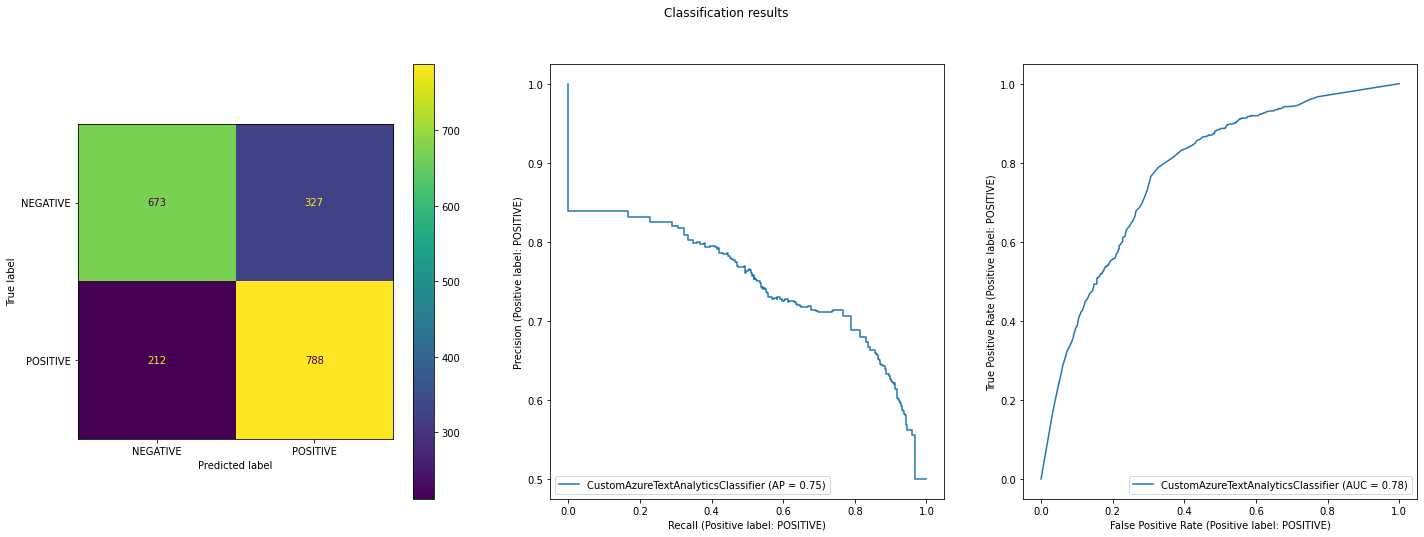

In [19]:
from models.custom_azure_text_analysis_classifier import (
    CustomAzureTextAnalyticsClassifier,
)


# Initialize Azure Text Analytics classifier
cls = CustomAzureTextAnalyticsClassifier(
    endpoint=AZURE_TEXT_ANALYTICS_ENDPOINT, key=AZURE_TEXT_ANALYTICS_KEY
)

cache_json_path = os.path.join("..", "results", "azure_cache.json")
if os.path.exists(cache_json_path):
    # Load cached results
    cls.load_cache_json(filename=cache_json_path)
else:
    # Compute sentiment scores
    cls.fit(X=df.text.values, y=df.target.values)
    # Save results to cache
    cls.save_cache_json(filename=cache_json_path)

# Plot classification performances
viz_helpers.plot_classifier_results(
    cls,
    df.text.values,
    df.target.values,
    title="Classification results",
)

The performances on the dataset are slightly better than our baseline model : 
- Average Precision = 0.75 (baseline = 0.73 , +2.7%)
- ROC AUC = 0.78 (baseline = 0.74 , +5.4%)



This model is also biased towards the positive class, but less than our baseline model : it predicted 26% (baseline = 35% , -26%) more _POSITIVE_ (1115) messages than _NEGATIVE_ (885).


In [20]:
df["api_positive"] = [cls.cache[text]["positive"] for text in df.text.values]
df["api_neutral"] = [cls.cache[text]["neutral"] for text in df.text.values]
df["api_negative"] = [cls.cache[text]["negative"] for text in df.text.values]

viz_helpers.plot_boxes(
    dataframe=df,
    plot_columns=["api_positive", "api_neutral", "api_negative"],
    categorical_column="target",
)

### Logistic Regression model based on Azure Cognitive Service for Language

In the previous model, we did not fully use the _neutral_ value (it was just considered as half positive and half negative). In order to use this information and try to remmove the bias from the basic model, we will train a logistic regression model on the sentiment values from the API.

In [21]:
from sklearn.model_selection import train_test_split


X = df[["api_positive", "api_neutral", "api_negative"]]
y = df.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [22]:
from sklearn.linear_model import LogisticRegressionCV


# Define model
model = LogisticRegressionCV(random_state=42)

# Train model
model.fit(X_train, y_train)

LogisticRegressionCV(random_state=42)

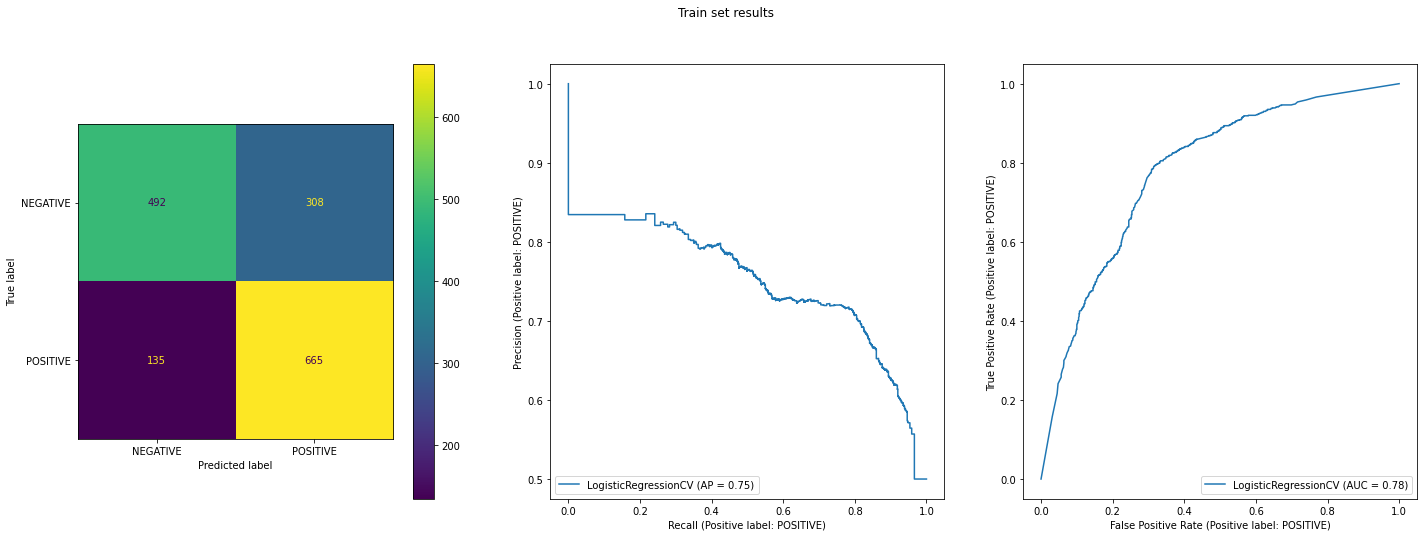

In [23]:
viz_helpers.plot_classifier_results(
    model,
    X_train,
    y_train,
    title="Train set results",
)

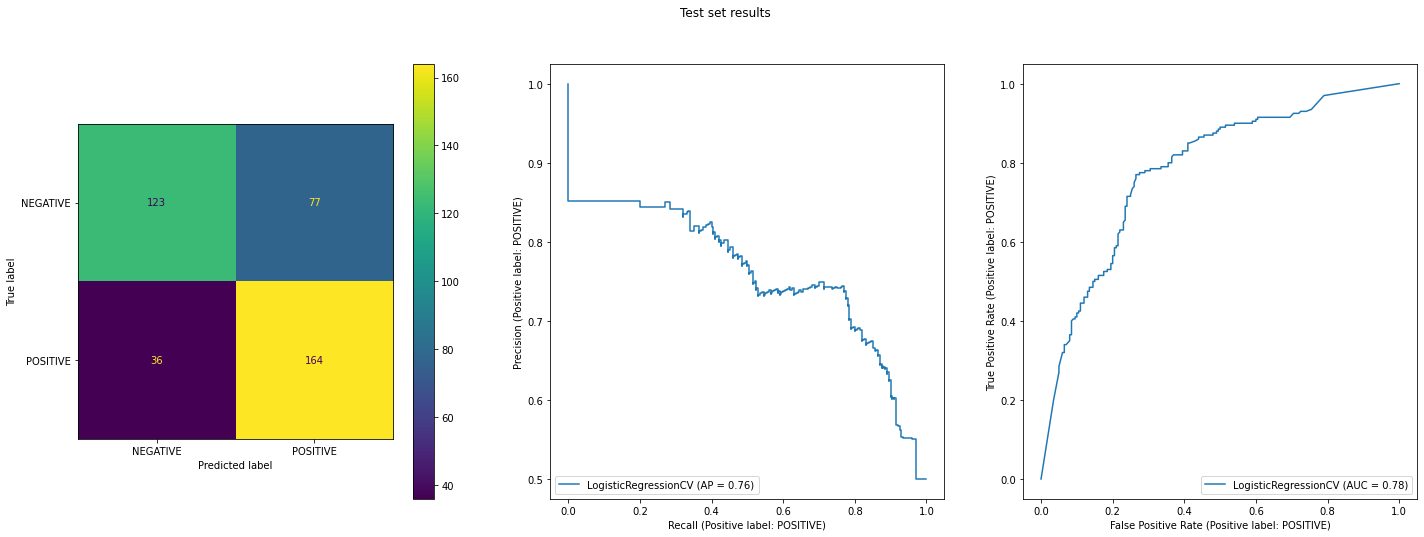

In [24]:
viz_helpers.plot_classifier_results(
    model,
    X_test,
    y_test,
    title="Test set results",
)

The performances on the train and test datasets are identical, so we know our model is well trained (no over/under-fitting). 

The new model has the same performance as our basic model.

Our model is even more biased towards the _POSITIVE_ class than the basic model : it predicted 54% (basic model = 26% , +107%) more _POSITIVE_ (1214) messages than _NEGATIVE_ (786).

Let's observe some classification errors.

In [25]:
# Compute predictions
y_pred = model.predict(X)
df["prediction"] = y_pred

In [26]:
import shap

shap.initjs()

explainer = shap.Explainer(model, X_train, feature_names=X.columns)
shap_values = explainer(X)

In [27]:
# False positive example
fp_index = df[(df.target == "NEGATIVE") & (df.prediction == "POSITIVE")].index[0]
fp_text = df.text.values[fp_index]

print(fp_text)

shap.plots.force(shap_values[fp_index])

A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now 


On this false-positive example, we can see that the model is not able to predict the _NEGATIVE_ sentiment of the message. It predicts a strong _POSITIVE_ sentiment even though the sentiment is rather mixed (the person seems to have a lot of work to do).

In [28]:
# False negative example
fn_index = df[(df.target == "POSITIVE") & (df.prediction == "NEGATIVE")].index[0]
fn_text = df.text.values[fn_index]

print(fn_text)

shap.plots.force(shap_values[fn_index])

Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x


On this false-negative example, we can see that the model is not able to predict the _POSITIVE_ sentiment of the message. But again in this case, the true sentiment is not obvious (the person is not happy to go to work).

## Models comparison

Training a logistic regression model on the sentiment values from the API has not improved the classification metrics and has worsen the bias towards the _POSITIVE_ class. We can see that the model is not able to predict the _NEGATIVE_ sentiment of the message.